# Car classification challenge

In [147]:
#import necessary libraries
import torch
from torch import nn
import os
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import shutil
from pathlib import Path
import tqdm
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from pytorch_lightning import LightningModule, Trainer
import sklearn

In [148]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the root directory where your dataset is located
root_directory = "DATA"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust as needed
    transforms.ToTensor(),
])

# Use ImageFolder to load the dataset
car_dataset = ImageFolder(root=root_directory, transform=transform)

# Create a DataLoader for iterating through the dataset in batches
batch_size = 32  # Adjust as needed
data_loader = DataLoader(car_dataset, batch_size=batch_size, shuffle=True)

# Print the class labels assigned by ImageFolder
print("Class Labels:", car_dataset.classes)


Class Labels: ['Golf', 'bmw serie 1', 'chevrolet spark', 'chevroulet aveo', 'clio', 'duster', 'hyundai i10', 'hyundai tucson', 'logan', 'megane', 'mercedes class a', 'nemo citroen', 'octavia', 'picanto', 'polo', 'sandero', 'seat ibiza', 'symbol', 'toyota corolla', 'volkswagen tiguan']


In [149]:
# split the dataset into train and test keeping the class labels and the number of images in each class
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(car_dataset, test_size=0.2, random_state=42, stratify=car_dataset.targets)


In [150]:
len(train_data), len(test_data)


(2588, 647)

In [151]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 5)

In [152]:
class_names = car_dataset.classes
class_names


['Golf',
 'bmw serie 1',
 'chevrolet spark',
 'chevroulet aveo',
 'clio',
 'duster',
 'hyundai i10',
 'hyundai tucson',
 'logan',
 'megane',
 'mercedes class a',
 'nemo citroen',
 'octavia',
 'picanto',
 'polo',
 'sandero',
 'seat ibiza',
 'symbol',
 'toyota corolla',
 'volkswagen tiguan']

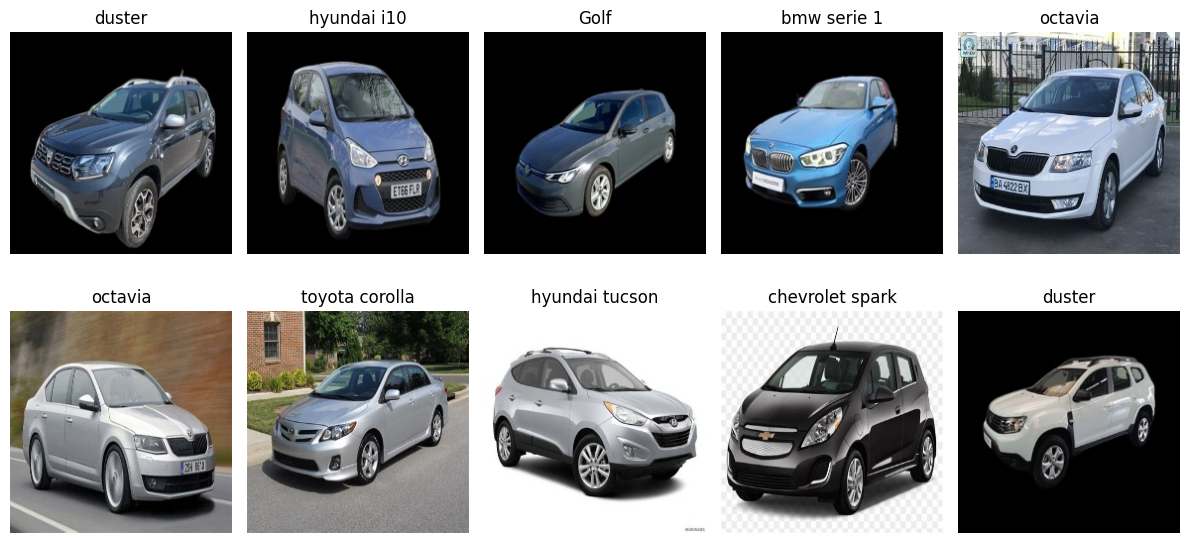

In [153]:
# plot the first 10 images in the dataset
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_data[i]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [154]:
# prepare a dataloader for training and testing
#Turn datasets into iterables
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


In [155]:
# check out what we´ve created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}....")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x1e81e48d0>, <torch.utils.data.dataloader.DataLoader object at 0x1ed988810>)
Length of train_dataloader: 81 batches of 32....
Length of test_dataloader: 21 batches of 32...


In [156]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skopt import BayesSearchCV

# Define the model with bayesian optimization
class CarsModelV1(nn.Module):
  def __init__(self, input_shape, output_shape, kernel_size, stride, padding):
    super(CarsModelV1, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=stride, padding=padding)
    self.fc1 = nn.Linear(128*26*26, 512)
    self.fc2 = nn.Linear(512, output_shape)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv3(x))
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)
    return x






In [172]:
#create a convolutional neural network class 
class cars(nn.Module):
    def __init__(self):
        super(cars, self).__init__()
        # input shape (3, 224, 224) final output shape: number of classes: 20
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7, stride=1, padding=0)
        # output shape (6, 218, 218)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # output shape (6, 109, 109)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # output shape (16, 105, 105)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        # output shape (32, 103, 103)
        self.fc1 = nn.Linear(32*50*50, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 32*50*50)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

In [141]:
import requests
from pathlib import Path
# Download helper functions from learn pytorch repo if not already downloaded

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary  

helper_functions.py already exists, skipping download


In [165]:

# Create an instance of the model
torch.manual_seed(42)
input_shape = (3, 224, 224)
class_names = 20
model_3 = cars()

In [166]:
# setup loss funtion/eval metrics/optimizer
import helper_functions
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(),lr=0.1)

In [167]:
#define train loop function
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device:torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

    #Add a loop through the training batches
  for batch, (X,y) in enumerate(data_loader):
    #Put data on target device
    X,y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate train loss
    train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1)) #go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step (update the model´s parameters once *per batch*)
    optimizer.step()

  # divide total train
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")





In [168]:
# define test loop function
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device:torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0,0 
  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      #Send the data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction lables
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%\n")                         


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


#train and test model
epochs = 15
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_3,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_3,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)



Epoch: 0
------
Train loss: 3.02971 | Train acc: 4.84%
Test loss: 3.03202 | Test_acc: 4.61%

Epoch: 1
------
Train loss: 3.02987 | Train acc: 4.83%
Test loss: 3.02139 | Test_acc: 5.68%

Epoch: 2
------
Train loss: 3.02976 | Train acc: 4.84%
Test loss: 3.03202 | Test_acc: 4.61%

Epoch: 3
------
Train loss: 3.02987 | Train acc: 4.83%
Test loss: 3.03202 | Test_acc: 4.61%

Epoch: 4
------
Train loss: 3.02982 | Train acc: 4.83%
Test loss: 3.02671 | Test_acc: 5.14%

Epoch: 5
------
Train loss: 3.02982 | Train acc: 4.83%
Test loss: 3.03202 | Test_acc: 4.61%

Epoch: 6
------
